In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files, drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
import cloudpickle as cp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('https://github.com/prasertcbs/tutorial/raw/master/msleep.csv')
df = df.sample(50, random_state=123)

# กำหนด path สำหรับบันทึกไฟล์ใน Google Drive
file_path = '/content/drive/MyDrive/IS_Final_Project/ML_Model/DatasetML/msleep_sample.csv'

# บันทึก DataFrame เป็นไฟล์ CSV ใน Google Drive
df.to_csv(file_path, index=False)

print(f"File saved to: {file_path}")

File saved to: /content/drive/MyDrive/IS_Final_Project/ML_Model/DatasetML/msleep_sample.csv


In [4]:
print("Missing Values:\n", df.isnull().sum()) # 4. ตรวจสอบค่า Missing Values

Missing Values:
 name             0
genus            0
vore             2
order            0
conservation    18
sleep_total      0
sleep_rem       15
sleep_cycle     31
awake            0
brainwt         15
bodywt           0
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 69 to 12
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          50 non-null     object 
 1   genus         50 non-null     object 
 2   vore          48 non-null     object 
 3   order         50 non-null     object 
 4   conservation  32 non-null     object 
 5   sleep_total   50 non-null     float64
 6   sleep_rem     35 non-null     float64
 7   sleep_cycle   19 non-null     float64
 8   awake         50 non-null     float64
 9   brainwt       35 non-null     float64
 10  bodywt        50 non-null     float64
dtypes: float64(6), object(5)
memory usage: 4.7+ KB


In [6]:
# ✅ 5. เติมค่า Missing ด้วย Mean
num_cols = ['bodywt', 'brainwt', 'sleep_total', 'sleep_rem', 'sleep_cycle', 'awake']
imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [7]:
# ✅ 6. One-Hot Encoding (ถ้ามีคอลัมน์ประเภทตัวอักษร)
cat_cols = ['vore'] if 'vore' in df.columns else []
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

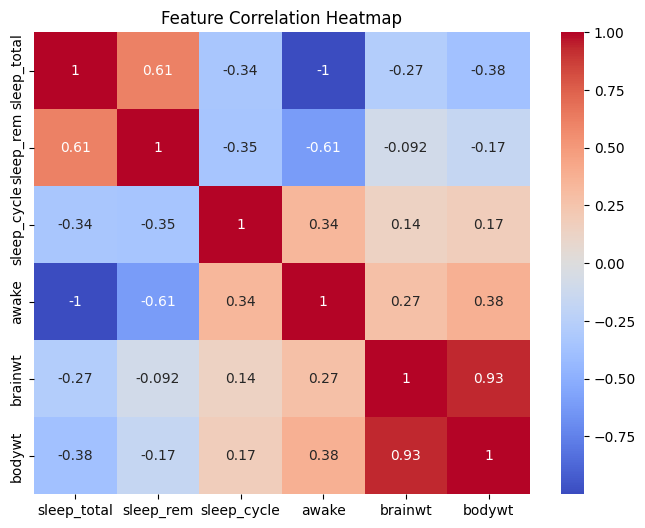

In [8]:
# ✅ 7. ดู Heatmap แสดงความสัมพันธ์ของ Features
plt.figure(figsize=(8, 6))
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
# ✅ 8. แยก Features & Target
X = df[['bodywt', 'brainwt', 'sleep_rem', 'sleep_cycle', 'awake']]
y = df['sleep_total']

In [10]:
# ✅ 9. Scaling ข้อมูล
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# ✅ 10. แบ่งชุด Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [12]:
# ✅ 10. Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [13]:
# ✅ 12. Evaluate Model
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Mean Squared Error (MSE): {mse:.4f}")
print(f"📈 R² Score (Test Data): {r2:.4f}")

# ✅ ตรวจสอบ Overfitting
train_r2 = lr_model.score(X_train, y_train)
test_r2 = lr_model.score(X_test, y_test)

print(f"🟢 Train R²: {train_r2:.4f}")
print(f"🔵 Test R²: {test_r2:.4f}")


📊 Mean Squared Error (MSE): 0.0000
📈 R² Score (Test Data): 1.0000
🟢 Train R²: 1.0000
🔵 Test R²: 1.0000


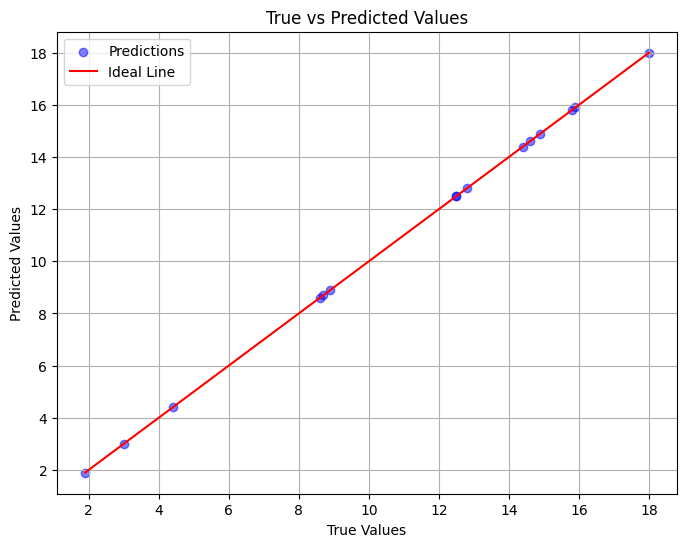

In [14]:
# ✅ พล็อตกราฟค่าจริงและค่าทำนาย
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Save using pickle
# Corrected path: changed 'ML_Modle' to 'ML_Model'
model_path = '/content/drive/MyDrive/IS_Final_Project/ML_Model/linear_regression_model.sav'
scaler_path = '/content/drive/MyDrive/IS_Final_Project/ML_Model/scaler.sav'
pickle.dump(lr_model, open(model_path, 'wb'))
pickle.dump(scaler, open(scaler_path, 'wb'))

# Load using pickle
loaded_lr_model = pickle.load(open(model_path, 'rb'))
loaded_scaler = pickle.load(open(scaler_path, 'rb'))

In [16]:
# ✅ 14. ทดสอบโมเดลที่โหลด
result = loaded_lr_model.score(X_test, y_test)
print(f"Model Accuracy (R² score): {result:.4f}")

Model Accuracy (R² score): 1.0000


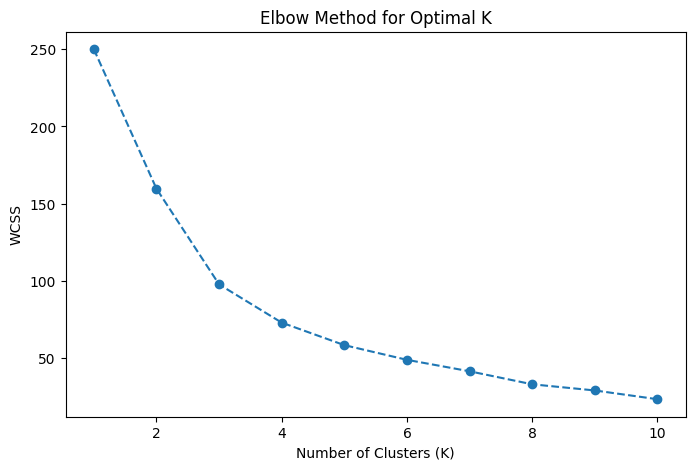

In [17]:
# ✅ 14. หาจำนวน Cluster ที่ดีที่สุด (Elbow Method)
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal K")
plt.show()

In [ ]:
# ✅ 15. Train K-Means Clustering (เลือก K=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [ ]:
# ✅ 17. บันทึก K-Means Model ด้วย pickle
kmeans_model_path = '/content/drive/MyDrive/IS_Final_Project/ML_Model/kmeans_model.sav'  # Use the Google Drive path here
pickle.dump(kmeans, open(kmeans_model_path, 'wb'))

In [ ]:
# ✅ 18. โหลด K-Means Model จาก Google Drive
kmeans_model_path = '/content/drive/MyDrive/IS_Final_Project/ML_Model/kmeans_model.sav'

# Make sure the file exists at this path in your Google Drive
# If the path is incorrect, update it accordingly.

# Load using cloudpickle (cp) because pickle might not work for all object types when loading from Google Drive.
# If you are sure it's a pickle object, try replacing cp with pickle
loaded_kmeans_model = cp.load(open(kmeans_model_path, 'rb'))

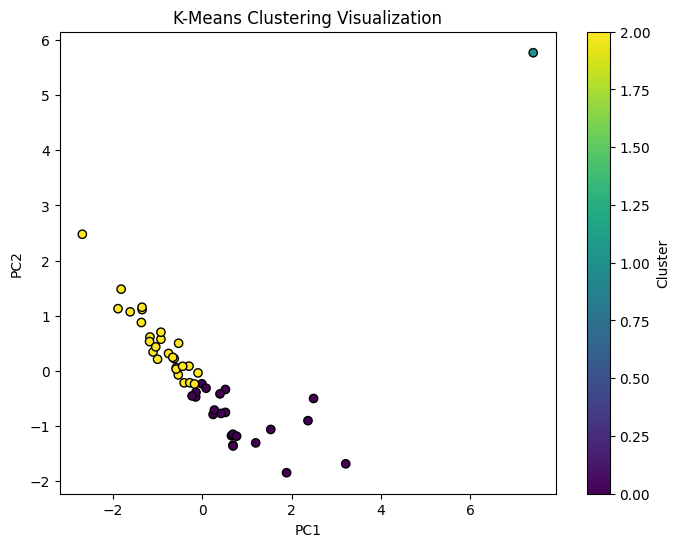

In [ ]:
# ✅ 17. PCA ลดมิติเป็น 2D เพื่อวาดกราฟ Clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis", edgecolors="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clustering Visualization")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
# ✅ 18. ดาวน์โหลดไฟล์โมเดลที่บันทึกไว้
files.download("/content/drive/MyDrive/IS_Final_Project/ML_Model/linear_regression_model.sav") # Change filename to match the saved filename
files.download("/content/drive/MyDrive/IS_Final_Project/ML_Model/scaler.sav") # Change filename to match the saved filename
files.download("/content/drive/MyDrive/IS_Final_Project/ML_Model/kmeans_model.sav") # Change filename to match the saved filename

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>